### Detail explanation can be found in the technical report 'Machine Learning Solutions for Combating Gender-Based Violence on Twitter. AE1'
### ALL cells has been ran

In [1]:
import pandas as pd #provides data structures for efficiently storing and analyzing data
import matplotlib.pyplot as plt #visualization library/  provides a simple interface for creating various types of plots and charts.
import seaborn as sns # It provides a high-level interface for creating aesthetically pleasing and informative statistical graphics.
from sklearn.feature_extraction.text import CountVectorizer #It is used to convert a collection of text documents into a matrix of token counts.
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS # a set of English stop words provided by Scikit-learn
from sklearn.naive_bayes import MultinomialNB #a classification algorithm provided by Scikit-learn, used for text classification tasks 
from sklearn.metrics import accuracy_score #calculate the accuracy of a classification model's predictions.
from sklearn.linear_model import LogisticRegression #a classification algorithm
from sklearn.feature_extraction.text import TfidfVectorizer#perform text vectorising
from sklearn.model_selection import train_test_split as split#for training classifier model
from sklearn.metrics import classification_report#produce classification report
from sklearn.model_selection import train_test_split
import numpy as np



### Text preproccessing

In [2]:
def clean_and_convert_text(raw_text):
    import unicodedata
    import nltk
    import string
    import contractions
    
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    
    def convert_utf(text):
        text = text.replace('\u2018', "'").replace('\u2019', "'").replace('\u201C', "`").replace('\u201D', "`").replace('\u2013', '-').replace('\u2014', '-')
        text = unicodedata.normalize('NFKD', text)
        text = text.encode('ascii', 'ignore')
        return text.decode('ascii')
    
    UTF_text = convert_utf(raw_text)
    normalised_text = UTF_text.lower()
    words = nltk.word_tokenize(normalised_text)
    
    #Remove punctuations and expand contractions
    words = [contractions.fix(word) for word in words if word not in string.punctuation]
    
    #Remove numbers and specific symbols
    words = [word for word in words if not word.isdigit() and word not in ['---', '...', '***']]
    
    #Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]
    
    return words


In [3]:
#Load the GBV dataset
GBV_train = pd.read_csv("archive/Train.csv", encoding='utf-8')
tweets = GBV_train['tweet']  #text data
categories = GBV_train['type']  #labels

#Preprocess the tweets
preprocessed_tweets = tweets.apply(clean_and_convert_text).str.join(' ')


### convert textual data to numbercal matrix

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=3, max_features=3000)#at least 3 documents of the corpus to be included in the resulting vocabulary. & limit the number of feature [1]
X = vectorizer.fit_transform(preprocessed_tweets).toarray()#[1] 


### convert string label 

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(categories)#[2]


### Sampling [3] [4] line 36

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)


In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)#[3 line 57] RandomOverSampler did not work, try alternative SMOTE
X_train, y_train = smote.fit_resample(X_train, y_train)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.5), #due the imblance nature of data, Dropout helps orevent overfittinvg
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')  #Adjust the output layer to match the types [3 line 69-97]
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])#[line 79] #Adam: adjusts the weights of the network to minimize the loss function.

## Neural network: [line 65]
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=120, epochs=10, shuffle=True)


Epoch 1/10
815/815 [==============================] - 2s 2ms/step - loss: 0.1368 - accuracy: 0.9709 - val_loss: 0.0139 - val_accuracy: 0.9951
Epoch 2/10
815/815 [==============================] - 2s 2ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 0.0119 - val_accuracy: 0.9961
Epoch 3/10
815/815 [==============================] - 2s 2ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0115 - val_accuracy: 0.9967
Epoch 4/10
815/815 [==============================] - 2s 2ms/step - loss: 8.4583e-04 - accuracy: 0.9999 - val_loss: 0.0146 - val_accuracy: 0.9967
Epoch 5/10
815/815 [==============================] - 2s 2ms/step - loss: 6.3331e-04 - accuracy: 0.9999 - val_loss: 0.0117 - val_accuracy: 0.9975
Epoch 6/10
815/815 [==============================] - 2s 2ms/step - loss: 3.7170e-04 - accuracy: 0.9999 - val_loss: 0.0116 - val_accuracy: 0.9975
Epoch 7/10
815/815 [==============================] - 2s 3ms/step - loss: 4.1618e-04 - accuracy: 0.9999 - val_loss: 0.0126 - val_accurac

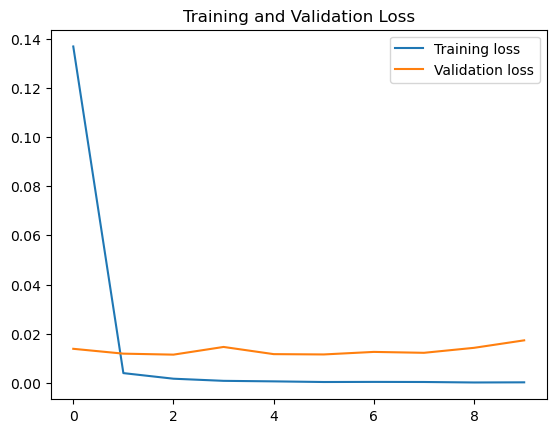

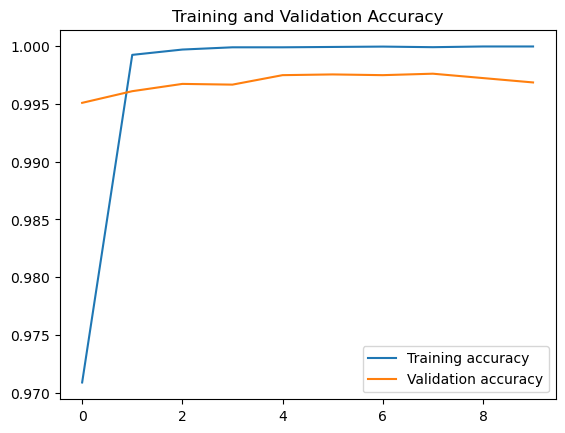

In [9]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


### Graph1(training and validation loss)  shows the model is generlaising well, the training loss starts high then maintian at a steady low level and validation loss matain at a low level overall, which means the model is able learn from the data. 

### Graph 2(training and valisation accuracy): the training accuracy rises sharply and maintain at a high performance, same with valisation accuracy, therefore also present the model is learning well from the data.

### Evaluation

In [10]:
evaluation = model.evaluate(X_test, y_test, verbose=1)
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

print(classification_report(y_test, predicted_classes))


496/496 [==============================] - 0s 363us/step
              precision    recall  f1-score   support

           0       0.98      0.86      0.92        71
           1       1.00      0.99      0.99      2389
           2       0.94      0.98      0.96        61
           3       0.98      0.99      0.98       251
           4       1.00      1.00      1.00     13088

    accuracy                           1.00     15860
   macro avg       0.98      0.96      0.97     15860
weighted avg       1.00      1.00      1.00     15860



In [11]:
from tensorflow.keras.models import save_model

# save model
save_model(model, "model.h5") #[6]


/var/folders/4b/s9j58ww53nn5b8fp3w7pvjvc0000gn/T/ipykernel_53285/29921106.py:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, "model.h5") #[6]


In [12]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import load_model

test_data = pd.read_csv("archive/Test.csv")

#Preprocess the test tweets
preprocessed_test_tweets = test_data['tweet'].apply(clean_and_convert_text).str.join(' ')

#Vectorize the preprocessed test tweets
X_test = vectorizer.transform(preprocessed_test_tweets).toarray()

#Load the  model
model = load_model("model.h5")

#Use the model to predict labels for the test data
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

test_data['predicted_label'] = label_encoder.inverse_transform(predicted_labels)

test_data.to_csv("Predicted_label_oversampling_DNN.csv", index=False)

# Display the first few rows of the test data with predicted labels
print("Test Data with Predicted Labels:")
print(test_data.head())

# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, predicted_classes))



487/487 [==============================] - 0s 384us/step
Test Data with Predicted Labels:
      Tweet_ID                                              tweet  \
0  ID_0095QL4S  because he was my boyfriend, and if I said no,...   
1  ID_00DREW5O  lol no, I'm telling you it's not legal. It's l...   
2  ID_00E9F5X9  Somalia's semi-autonomous Puntland region has ...   
3  ID_00G9OSKZ  University of Cape Coast students being robbed...   
4  ID_00HU96U6  "Somebody came up behind him and stabbed him i...   

                predicted_label  
0               sexual_violence  
1  Harmful_Traditional_practice  
2  Harmful_Traditional_practice  
3               sexual_violence  
4               sexual_violence  

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92        71
           1       1.00      0.99      0.99      2389
           2       0.94      0.98      0.96        61
           3       0.98      0.99      0.98       

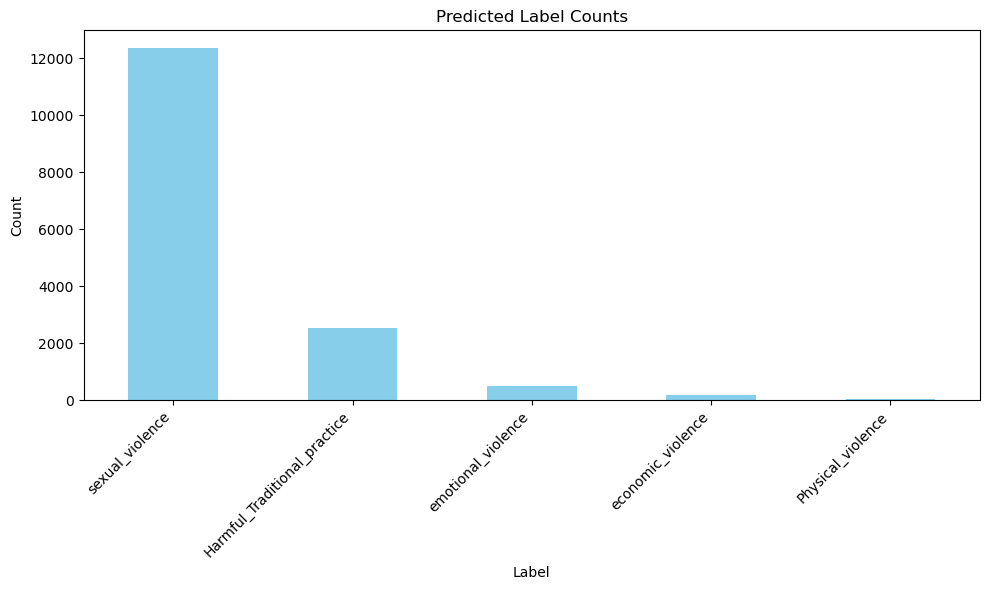

In [13]:
import matplotlib.pyplot as plt

#Count occurrences 
predicted_label_counts = test_data['predicted_label'].value_counts()

#Plotting the bar chart
plt.figure(figsize=(10, 6))
predicted_label_counts.plot(kind='bar', color='skyblue')
plt.title('Predicted Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Bibliography
[1]Scikit learn, “sklearn.feature_extraction.text.TfidfVectorizer — scikit-learn 0.20.3 documentation,” Scikit-learn.org, 2018. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
[2]scikit-learn developers, “sklearn.preprocessing.LabelEncoder — scikit-learn 0.22.1 documentation,” Scikit-learn.org, 2019. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
[3]“GenderViolence/Training.py at main · ccastore/GenderViolence,” GitHub. https://github.com/ccastore/GenderViolence/blob/main/Training.py (accessed Apr. 18, 2024).[4]“SMOTE — Version 0.9.0,” imbalanced-learn.org. https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
[5]K. Team, “Keras documentation: Training & evaluation with the built-in methods,” keras.io. https://keras.io/guides/training_with_built_in_methods/
[6]K. Team, “Keras documentation: Save, serialize, and export models,” Keras.io, 2023. https://keras.io/guides/serialization_and_saving/